In [1]:
#loading the imgs to the environment
!tar xzvf /kaggle/input/cifar10-python/cifar-10-python.tar.gz
def load_data():
    """Loads CIFAR10 dataset.
    Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    import os
    import sys
    from six.moves import cPickle
    
    def load_batch(fpath):
        with open(fpath, 'rb') as f:
            d = cPickle.load(f, encoding='bytes')  
        data = d[b'data']
        labels = d[b'labels']
        data = data.reshape(data.shape[0], 3, 32, 32)
        return data, labels
    
    path = 'cifar-10-batches-py'
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000:i * 10000, :, :, :],
         y_train[(i - 1) * 10000:i * 10000]) = load_batch(fpath)
    
    x_test, y_test = load_batch(os.path.join(path, 'test_batch'))

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
import numpy as np
#I'm not resizing the img as it's all ready small
(x_train, y_train), (x_test, y_test) = load_data()
print(np.unique(y_train))
nb_classes = len(np.unique(y_train))
print('the num of classes',nb_classes)

[0 1 2 3 4 5 6 7 8 9]
the num of classes 10


In [4]:
#kinda Noramalizing the img
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

In [5]:
#we have 50000 imgs with the size of 32*32 and are RBG in nature
print(x_train.shape)
print(y_train.shape)
#we have 10000 imgs with the size of 32*32 and are RBG in nature
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


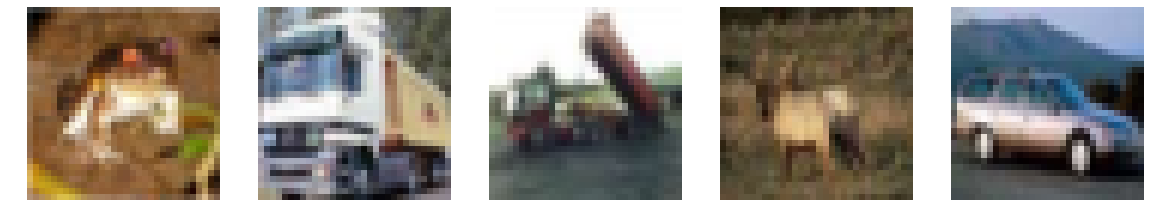

In [6]:
#Sample, lets polt a image and see what it looks like
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

hmm, theres still a essence of the image felt behind as that will help the CNN to learn the diffrence

## Model

In [7]:
model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='same',
                        input_shape=(32,32,3), 
                        activation='relu'))
model.add(Convolution2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [8]:
base_model= model.fit(x_train, y_train, batch_size=60,epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 236us/step - loss: 1.4938 - accuracy: 0.4533 - val_loss: 1.1373 - val_accuracy: 0.5962
Epoch 2/10
50000/50000 [==============================] - 8s 152us/step - loss: 1.0659 - accuracy: 0.6226 - val_loss: 0.9624 - val_accuracy: 0.6661
Epoch 3/10
50000/50000 [==============================] - 7s 150us/step - loss: 0.8783 - accuracy: 0.6915 - val_loss: 0.8302 - val_accuracy: 0.7139
Epoch 4/10
50000/50000 [==============================] - 7s 149us/step - loss: 0.7610 - accuracy: 0.7343 - val_loss: 0.7803 - val_accuracy: 0.7301
Epoch 5/10
50000/50000 [==============================] - 8s 155us/step - loss: 0.6742 - accuracy: 0.7619 - val_loss: 0.7530 - val_accuracy: 0.7381
Epoch 6/10
50000/50000 [==============================] - 8s 152us/step - loss: 0.6080 - accuracy: 0.7864 - val_loss: 0.7159 - val_accuracy: 0.7557
Epoch 7/10
50000/50000 [==============================] - 8s 

I'm not happy, its quite over fitting 

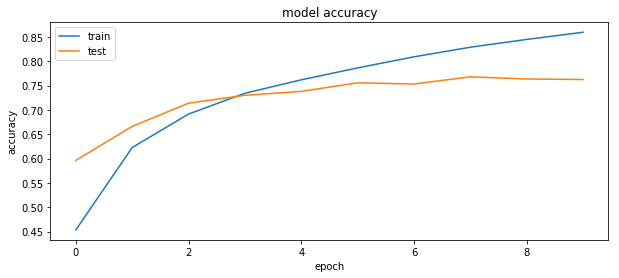

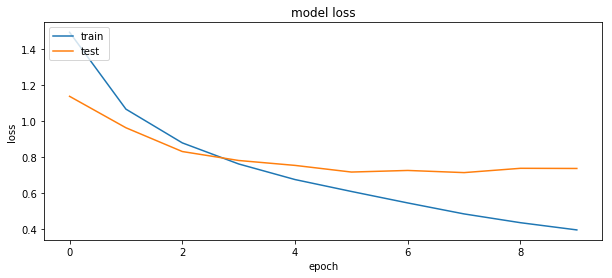

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 4
plt.plot(base_model.history['accuracy'])
plt.plot(base_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(base_model.history['loss'])
plt.plot(base_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [11]:
model_2 = Sequential()

model_2.add(Conv2D(32,(3,3),activation = "relu", input_shape=(32,32,3)))
model_2.add(Conv2D(32,(3,3),activation = "relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.5))
model_2.add(Dense(64, activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.5))

model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(nb_classes, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.002), metrics=["accuracy"])
#Learning rate(lr) can a be a game changer but as
#we all know the smaller the better for the GD and to find the Globel min.
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 9, 9, 64)          2112      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 64)         

In [12]:
cnn_2 = model_2.fit(x_train, y_train, batch_size=100, epochs=100, verbose=1,validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 106us/step - loss: 0.2862 - accuracy: 0.8998 - val_loss: 0.2859 - val_accuracy: 0.9074
Epoch 2/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.2406 - accuracy: 0.9074 - val_loss: 0.2611 - val_accuracy: 0.9120
Epoch 3/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.2275 - accuracy: 0.9117 - val_loss: 0.2459 - val_accuracy: 0.9167
Epoch 4/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.2192 - accuracy: 0.9147 - val_loss: 0.2293 - val_accuracy: 0.9198
Epoch 5/100
50000/50000 [==============================] - 5s 97us/step - loss: 0.2123 - accuracy: 0.9169 - val_loss: 0.2222 - val_accuracy: 0.9241
Epoch 6/100
50000/50000 [==============================] - 6s 112us/step - loss: 0.2069 - accuracy: 0.9194 - val_loss: 0.2223 - val_accuracy: 0.9222
Epoch 7/100
50000/50000 [==============================] - 5

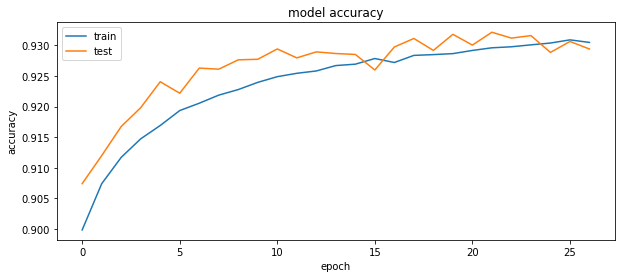

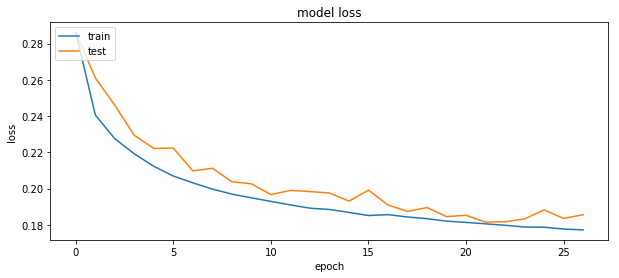

In [13]:
rcParams['figure.figsize'] = 10, 4
plt.plot(cnn_2.history['accuracy'])
plt.plot(cnn_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_2.history['loss'])
plt.plot(cnn_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
#Knowing that this a models ability to learn is quit good so
#save em load em, rum em!
from keras.models import load_model
model_2.save_weights('Cnn_weights.h5')

In [15]:
#Know that my model is outsmarting the test fellow, just gen more image to both the side, hopping to leave out the plane on both end.
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


datagen.fit(x_test)

In [16]:
model_2 = Sequential()

model_2.add(Conv2D(32,(3,3),activation = "relu", input_shape=(32,32,3)))
model_2.add(Conv2D(32,(3,3),activation = "relu"))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Dropout(0.5))
model_2.add(Conv2D(64,(3,3),activation = "relu"))

model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(nb_classes, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=["accuracy"])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [17]:
# Transfer-learning
model_2.load_weights('Cnn_weights.h5', by_name=True)


cnn_2 = model_2.fit(x_train, y_train, batch_size=60, epochs=100, verbose=1,validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 7s 148us/step - loss: 0.2376 - accuracy: 0.9119 - val_loss: 0.1944 - val_accuracy: 0.9252
Epoch 2/100
50000/50000 [==============================] - 7s 139us/step - loss: 0.1811 - accuracy: 0.9300 - val_loss: 0.1706 - val_accuracy: 0.9332
Epoch 3/100
50000/50000 [==============================] - 7s 142us/step - loss: 0.1574 - accuracy: 0.9388 - val_loss: 0.1538 - val_accuracy: 0.9397
Epoch 4/100
50000/50000 [==============================] - 7s 138us/step - loss: 0.1447 - accuracy: 0.9436 - val_loss: 0.1467 - val_accuracy: 0.9428
Epoch 5/100
50000/50000 [==============================] - 7s 131us/step - loss: 0.1346 - accuracy: 0.9475 - val_loss: 0.1403 - val_accuracy: 0.9462
Epoch 6/100
50000/50000 [==============================] - 7s 132us/step - loss: 0.1275 - accuracy: 0.9504 - val_loss: 0.1405 - val_accuracy: 0.9458
Epoch 7/100
50000/50000 [==============================]

In [18]:
model_2.save_weights('Cnn_2_weights.h5')

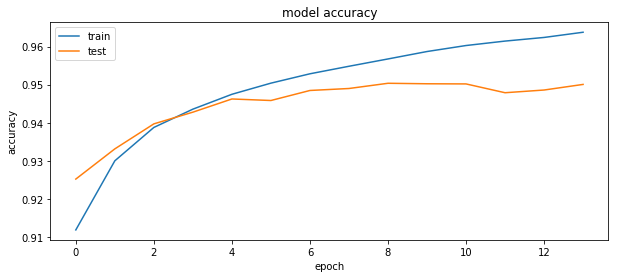

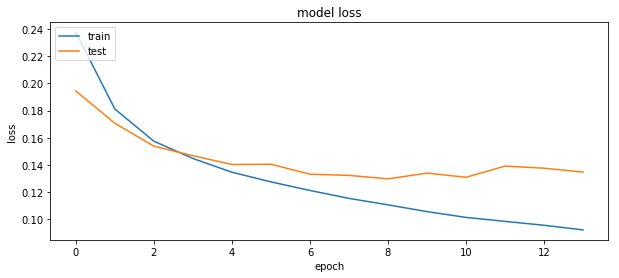

In [19]:
rcParams['figure.figsize'] = 10, 4
plt.plot(cnn_2.history['accuracy'])
plt.plot(cnn_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_2.history['loss'])
plt.plot(cnn_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 even though sweet sport for my model at 95% acc currently even after playing whit the hyperparamenter for a while like whit lr,layers, num of neurons and architecture , well its time to borrow Vgg nets architecture from google!

In [20]:
#Almost close to VGGs architecture, atlest this architecture follows the flow of the how the architecture
#was made.
model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(16, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(8, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Flatten())
model_2.add(Dense(32, activation='relu'))
model_3.add(Dense(nb_classes, activation='sigmoid'))


model_3.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.002), metrics=["accuracy"])
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 8)           1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 8)          

In [21]:
model_3.load_weights('Cnn_2_weights.h5', by_name=True)

cnn_3 = model_3.fit(x_train, y_train, batch_size=60, epochs=70, verbose=1,validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

Train on 50000 samples, validate on 10000 samples
Epoch 1/70
50000/50000 [==============================] - 7s 138us/step - loss: 0.3034 - accuracy: 0.8955 - val_loss: 0.2770 - val_accuracy: 0.8978
Epoch 2/70
50000/50000 [==============================] - 6s 128us/step - loss: 0.2645 - accuracy: 0.9025 - val_loss: 0.2529 - val_accuracy: 0.9045
Epoch 3/70
50000/50000 [==============================] - 6s 128us/step - loss: 0.2497 - accuracy: 0.9060 - val_loss: 0.2420 - val_accuracy: 0.9077
Epoch 4/70
50000/50000 [==============================] - 6s 125us/step - loss: 0.2394 - accuracy: 0.9088 - val_loss: 0.2340 - val_accuracy: 0.9093
Epoch 5/70
50000/50000 [==============================] - 6s 130us/step - loss: 0.2319 - accuracy: 0.9115 - val_loss: 0.2311 - val_accuracy: 0.9117
Epoch 6/70
50000/50000 [==============================] - 7s 149us/step - loss: 0.2255 - accuracy: 0.9139 - val_loss: 0.2331 - val_accuracy: 0.9101
Epoch 7/70
50000/50000 [==============================] - 7s 1

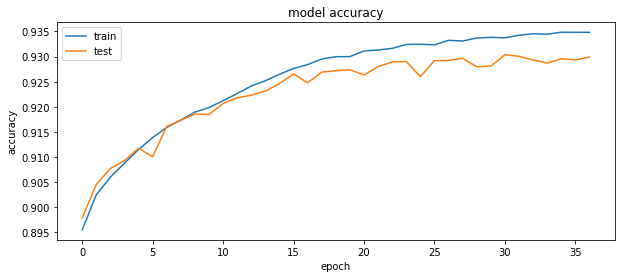

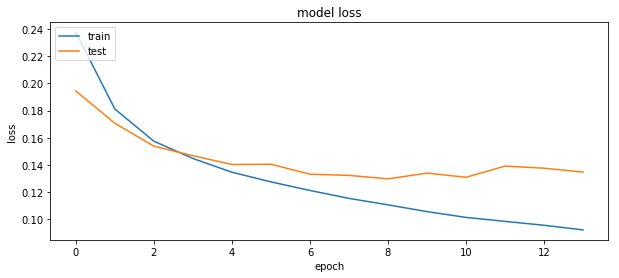

In [22]:
rcParams['figure.figsize'] = 10, 4
plt.plot(cnn_3.history['accuracy'])
plt.plot(cnn_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_2.history['loss'])
plt.plot(cnn_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model_3.save_weights('Cnn_3=cnn2+1_weights.h5')

### Conclusion
Using DenseNet I managed to get about 90% and whit VGG net it was about 94% accuracy on test dataset

with the architecture(model_2) that I have come up could go up to 95% accuracy on test quit overfitting model, but the others(base_model and model_3) are reliable with a accuracy of 93% 

and please do share the code/paper if anyone as hit 97% accuracy on the test, curious to know the architecture/tricks thay have used.